# Loan Default Prediction - Classification

## Part 2. Data Cleaning + Feature Engineering

**This notebook contains code for:**
1. **Data cleaning,**
2. **Feature engineering.**

---

<a id ='toc'></a>
**Table of Contents**
1. [Data Cleaning](#clean)
    1. [Drop unwanted observations/features:](#clean)
        1. [Irrelevant](#clean)
        2. [Duplicates](#dups)
    2. [Fix structural errors](#strut)
        1. [categorical to numerical](#ctn)
        2. [categorical to ordinal](#cto)
        3. [categorical to datetime](#ctd)
        4. [typos, inconsistencies](#typo)
    3. [Outliers](#out)
    4. [Missing values](#miss)
        1. [Categorical](#miss)
        2. [Numerical](#m-num)
            1. [drop sparse columns](#sparse)
            2. [investigate reasons for missing values](#reason)
            3. [impute numerical missing values](#impute)
            4. [save imputing informaiton for future use](#save)

2. [Feature Engineering](#fe)
    1. [New features](#fe)
    2. [One hot encoding](#dummy)
    
3. [Save File](#abt)

4. [Notes](#notes)
---

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 150)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, f_classif

import pickle

In [2]:
# import master loan file
%%time
df = pd.read_csv('../data/master_loan_datav2019q3.csv', low_memory = False)

CPU times: user 1min 4s, sys: 5.32 s, total: 1min 9s
Wall time: 1min 9s


In [3]:
df.shape

(2650518, 150)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,NaN,May-2019,714.0,710.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,N

[back to top](#toc)

<a id = 'clean'></a>
### 1. Data Cleaning
<a id = 'drop'></a>
#### 1.A. Drop unwanted
##### 1.A.a. Irrelevant
1. Rows:
      1. ~'loan_status'~: keep only 'Fully Paid'(0) and 'Charged Off'(1), per only closed loans has definite loan_status
      2. ~'grade'~: keep only A-D, per platform new policy of issuing grade A-D loans only
      3. ~'sub_grade'~: keep only A-D, per platform new policy of issuing grade A-D loans only
      4. ~'initial_list_status'~: keep only 'f', per personal preference of fractional loans
2. [Columns:](#cols)
      1. data leakage: ~columns non-existent in the open loan data~ (40)
      2. [non-informational](#noninf): ~'id', 'url'~ (2) 
      3. nlp (require more processing to be useful): ~'emp_title', 'desc', 'title'~ (3)
      4. zero variance: ~'pymnt_plan'(pre dropped in data leakage step), 'member_id', 'initial_list_status'~ (2)
      5. geospatial (require more processing to be useful): ~'zip_code', 'addr_state'~
      6. redundant: ~keep one of ('loan_amnt','funded_amnt','funded_amnt_inv')~
      
      
[back to top](#toc)

**1.A.a.1.A. Drop rows - 'loan_status': keep only 'Fully Paid'(0) and 'Charged Off'(1)**

In [5]:
# 'loan_status': keep only 'Fully Paid'(0) and 'Charged Off'(1)
df.loan_status.value_counts()

Fully Paid                                             1319751
Current                                                 969934
Charged Off                                             321940
Late (31-120 days)                                       24336
In Grace Period                                           7594
Late (16-30 days)                                         4168
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     45
Name: loan_status, dtype: int64

In [6]:
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])]
print (df.shape)
df.loan_status.value_counts()

(1641691, 150)


Fully Paid     1319751
Charged Off     321940
Name: loan_status, dtype: int64

In [7]:
df.loan_status.head()

0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
4     Fully Paid
Name: loan_status, dtype: object

In [8]:
# encode loan_status
df.loc[:, 'loan_status'] = df.loan_status.replace({'Fully Paid': 0, 'Charged Off': 1})
print (df.loan_status.head())
df.loan_status.value_counts()

0    0
1    1
2    0
3    0
4    0
Name: loan_status, dtype: int64


0    1319751
1     321940
Name: loan_status, dtype: int64

In [9]:
# master portfolio default rate
df.loan_status.mean()

0.19610267705676646

**1.A.a.1.B. Drop rows -'grade': keep only A-D**

In [10]:
# current grades available
df.grade.value_counts()

B    481775
C    466842
A    295988
D    243456
E    108096
F     35342
G     10192
Name: grade, dtype: int64

In [11]:
df.grade.head()

0    B
1    C
2    C
3    C
4    B
Name: grade, dtype: object

In [12]:
# keep loans that are in grade A-D only
df = df.loc[df.grade.isin(list('ABCD')), :]
print(df.grade.head())
print(df.grade.value_counts())

0    B
1    C
2    C
3    C
4    B
Name: grade, dtype: object
B    481775
C    466842
A    295988
D    243456
Name: grade, dtype: int64


**1.A.a.1.C. Drop rows - 'sub_grade': keep only A-D**

In [13]:
df.sub_grade.value_counts().sort_index()

A1     56641
A2     47034
A3     48449
A4     65954
A5     77910
B1     88487
B2     90353
B3     98184
B4    102101
B5    102650
C1    104852
C2     96064
C3     91630
C4     91029
C5     83267
D1     61839
D2     55101
D3     47811
D4     42618
D5     36087
Name: sub_grade, dtype: int64

In [14]:
df.shape

(1488061, 150)

**1.A.a.1.D. Drop rows - 'initial_list_status': keep only 'f'**

In [15]:
df.initial_list_status.value_counts()

w    942347
f    545714
Name: initial_list_status, dtype: int64

In [16]:
df = df.loc[(df.initial_list_status  == 'f'), :]
print (df.shape)
df.initial_list_status.value_counts()

(545714, 150)


f    545714
Name: initial_list_status, dtype: int64

[back to Drop list](#drop)
<a id = 'cols'></a>

**1.A.a.2.A. Drop columns - data leakage: drop columns non-existent in the open loan data**

In [18]:
# load sample open loan data
df_open = pd.read_csv('../data/open_loan_datav20200120.csv', low_memory = False)
df_open.shape

(67, 122)

In [19]:
df_open.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,accept_d,exp_d,list_d,credit_pull_d,review_status_d,review_status,url,desc,purpose,title,zip_code,addr_state,msa,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_recent_bc,mort_acc,open_acc,pub_rec,total_bal_ex_mort,revol_bal,revol_util,total_bc_limit,total_acc,total_il_high_credit_limit,num_rev_accts,mths_since_recent_bc_dlq,initial_list_status,ils_exp_d,pub_rec_bankruptcies,num_accts_ever_120_pd,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,mths_since_last_major_derog,num_sats,num_tl_op_past_12m,mo_sin_rcnt_tl,tot_hi_cred_lim,tot_cur_bal,avg_cur_bal,num_bc_tl,num_actv_bc_tl,num_bc_sats,pct_tl_nvr_dlq,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,effective_int_rate,application_type,disbursement_method,annual_inc_joint,dti_joint,verified_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mtg_payment,housing_payment,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,164695726,207634668,12800.0,12300.0,60,12.40,5.53,0.75,287.33,B,B4,Shop Technician,< 1 year,RENT,24996.0,Source Verified,01-09-2020 11:37:25,02-16-2020 10:00:00,01-17-2020 10:00:00,01-09-2020 10:53:03,01-17-2020 05:56:49,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,358xx,AL,NaN,0,3,492,75.0,91.9,21.99,0,0.0,08-08-2015 17:00:00,660,664,0,,,18,,4,0,6,0,17034,7890.0,82.2,6100,7,11945,5,,f,NaN,0,0,0,0,0,NaN,6,1,4,21545,17034,2839,4,4,4,100,0,0,0,2,31,5,53,4,9600,5,5,0,12.28,INDIVIDUAL,DIRECT_PAY,,,,1,1,0,1,22,9144.0,76.6,1,2,1962.0,79.1,0,2,0,0.0,,,,,,,,,,,,,,
1,164622488,207519431,40000.0,35750.0,36,12.40,5.36,1.05,1336.23,B,B4,NaN,< 1 year,RENT,150000.0,Not Verified,01-08-2020 09:53:32,02-07-2020 14:00:00,01-08-2020 14:00:00,01-08-2020 09:50:52,01-08-2020 10:01:02,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,275xx,NC,NaN,0,3,9062,72.7,85.6,24.14,0,0.0,01-07-2013 16:00:00,695,699,0,,,21,,22,0,21,0,82880,61261.0,71.7,62800,26,49129,24,,f,NaN,0,0,0,0,0,NaN,21,0,21,134629,82880,4604,18,11,14,100,0,0,0,2,41,14,84,21,85500,14,19,0,12.27,INDIVIDUAL,CASH,,,,0,2,0,0,31,21619.0,44.0,0,3,14453.0,61.6,0,0,0,0.0,,,,,,,,,,,,,,
2,164602477,207504051,20000.0,14025.0,60,18.62,13.06,1.14,514.64,D,D1,Maintenance,7 years,RENT,35000.0,Verified,01-08-2020 12:38:49,02-12-2020 10:00:00,01-13-2020 10:00:00,01-08-2020 04:30:15,01-13-2020 05:53:08,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,131xx,NY,NaN,0,3,5000,0.0,0.0,35.36,0,0.0,11-07-2013 16:00:00,690,694,0,,79,2,,61,0,6,1,48597,5298.0,33.1,5000,9,46528,4,,f,NaN,1,0,0,0,0,NaN,6,2,7,62528,48597,8100,2,0,2,100,0,0,0,5,42,1,74,44,16000,1,4,0,17.81,JOINT,CASH,70000.0,18.1,Verified,0,2,2,3,7,43299.0,93.1,0,0,0.0,77.7,5,1,7,0.0,,21405,660,664,03-07-2003 16:00:00,0,0,3,2.3,1,2,0,0,
3,164049165,206864945,25000.0,8525.0,36,16.12,7.96,1.23,880.41,C,C3,Field supervisor,6 years,MORTGAGE,60000.0,Verified,01-04-2020 12:32:39,02-18-2020 12:36:57,01-20-2020 10:00:00,12-28-2019 08:28:47,01-20-2020 05:52:44,Approved,https://lendingclub.com/browse/loanDetail.acti...,

In [20]:
cols_open = df_open.columns.tolist()
len(cols_open)

122

In [21]:
cols_master = df.columns.tolist()
len(cols_master)

150

In [22]:
# columns exist after loan issuance
cols_in_master_notin_open = [col for col in cols_master if col not in cols_open]
len(cols_in_master_notin_open)

44

In [23]:
cols_in_master_notin_open

['funded_amnt_inv',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'policy_code',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [24]:
# columns that are available only before loan issuance
# need to drop when build prediction model for new loans
cols_in_open_notin_master = [col for col in cols_open if col not in cols_master]
len(cols_in_open_notin_master)

16

In [25]:
cols_in_open_notin_master

['exp_default_rate',
 'service_fee_rate',
 'is_inc_v',
 'accept_d',
 'exp_d',
 'list_d',
 'credit_pull_d',
 'review_status_d',
 'review_status',
 'msa',
 'ils_exp_d',
 'effective_int_rate',
 'disbursement_method',
 'verified_status_joint',
 'mtg_payment',
 'housing_payment']

In [26]:
df_open.is_inc_v.value_counts()

Not Verified       42
Source Verified    21
Verified            4
Name: is_inc_v, dtype: int64

In [27]:
df.verification_status.value_counts()

Source Verified    196789
Not Verified       174823
Verified           174102
Name: verification_status, dtype: int64

In [28]:
df_open.verified_status_joint.value_counts()

                   56
Not Verified        9
Verified            1
Source Verified     1
Name: verified_status_joint, dtype: int64

In [29]:
df.verification_status_joint.value_counts()

Not Verified       4063
Source Verified    1776
Verified           1233
Name: verification_status_joint, dtype: int64

In [30]:
# correct naming inconsistency for the same feature before and after loan issuance
df = df.rename(columns = {'verification_status': 'is_inc_v', 
                     'verification_status_joint': 'verified_status_joint'})

In [31]:
cols_master = df.columns.tolist()

In [32]:
cols_in_master_notin_open = [col for col in cols_master if col not in cols_open]
len(cols_in_master_notin_open)

42

In [33]:
cols_in_master_notin_open

['funded_amnt_inv',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'policy_code',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [34]:
cols_drop_notin_open = [col for col in cols_in_master_notin_open 
                        if col not in [ 'issue_d','loan_status']]
len(cols_drop_notin_open)

40

In [35]:
# columns to be dropped as they are not available before loan issuance/data leakage
cols_drop_notin_open

['funded_amnt_inv',
 'pymnt_plan',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'policy_code',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [36]:
df.shape

(545714, 150)

In [37]:
df = df.drop(cols_drop_notin_open, axis = 1)
df.shape

(545714, 110)

In [38]:
[col for col in df.columns.tolist() if col not in cols_open]

['issue_d', 'loan_status']

[back to Drop list](#drop)
<a id = 'noninf'></a>

**1.A.a.2.B. Drop columns - non-informational: 'id', 'url'**
- check whether 'id' is chornological before dropping: if so, could be used as train/test spliting flag

In [45]:
df.loc[:, 'id'] = df.id.astype('int')

In [49]:
df.id.describe()

count    5.457140e+05
mean     4.482794e+07
std      4.046754e+07
min      5.473400e+04
25%      7.069044e+06
50%      3.848431e+07
75%      7.554799e+07
max      1.594194e+08
Name: id, dtype: float64

In [48]:
df.groupby(['issue_d']).id.agg(['min', 'max']).sort_values(by = 'min')

,min,max
issue_d,,
Aug-2009,54734,437580
May-2008,55742,348522
Aug-2014,57167,26407754
Mar-2010,57245,499328
Nov-2009,57416,463130
Aug-2012,58524,1503155
Apr-2008,58915,345705
Sep-2009,59006,445340
Feb-2010,61390,489422


In [51]:
df[['id', 'url']].head()

,id,url
0,1077501,https://lendingclub.com/browse/loanDetail.acti...
1,1077430,https://lendingclub.com/browse/loanDetail.acti...
2,1077175,https://lendingclub.com/browse/loanDetail.acti...
3,1076863,https://lendingclub.com/browse/loanDetail.acti...
4,1075358,https://lendingclub.com/browse/loanDetail.acti...


In [52]:
df = df.drop(['id', 'url'], axis = 1)
df.shape

(545714, 108)

[back to Drop list](#drop)

**1.A.a.2.C. Drop columns - nlp: 'emp_title', 'desc', 'title'**

In [53]:
df[['emp_title', 'desc', 'title']].head()

,emp_title,desc,title
0,NaN,Borrower added on 12/22/11 > I need to upgra...,Computer
1,Ryder,Borrower added on 12/22/11 > I plan to use t...,bike
2,NaN,NaN,real estate business
3,AIR RESOURCES BOARD,Borrower added on 12/21/11 > to pay for prop...,personel
4,University Medical Group,Borrower added on 12/21/11 > I plan on combi...,Personal


In [54]:
df[['emp_title', 'desc', 'title']].describe()

,emp_title,desc,title
count,508644,98086,541802
unique,207161,97147,49339
top,Teacher,,Debt consolidation
freq,7503,209,230472


In [55]:
df = df.drop(['emp_title', 'desc', 'title'], axis = 1)
df.shape

(545714, 105)

[back to Drop list](#drop)

**1.A.a.2.D. Drop columns - zero variance: 'member_id', 'initial_list_status'**

In [56]:
df[['member_id']].describe()

,member_id
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [57]:
df.initial_list_status.describe()

count     545714
unique         1
top            f
freq      545714
Name: initial_list_status, dtype: object

In [58]:
df[['member_id', 'initial_list_status']].head()

,member_id,initial_list_status
0,NaN,f
1,NaN,f
2,NaN,f
3,NaN,f
4,NaN,f


In [59]:
df = df.drop(['member_id', 'initial_list_status'], axis = 1)
df.shape

(545714, 103)

[back to Drop list](#drop)

**1.A.a.2.E. Drop columns - geospatial: 'zip_code', 'addr_state'**

In [60]:
df[['zip_code', 'addr_state']].describe()

,zip_code,addr_state
count,545713,545714
unique,918,51
top,945xx,CA
freq,6135,81846


In [61]:
df = df.drop(['zip_code', 'addr_state'], axis = 1)
df.shape

(545714, 101)

[back to Drop list](#drop)

**1.A.a.2.F. Drop columns - redundant: keep one of ['loan_amnt','funded_amnt']**

In [62]:
df[['loan_amnt','funded_amnt']].describe()

,loan_amnt,funded_amnt
count,545714.000000,545714.000000
mean,13243.692346,13228.052286
std,8285.958311,8278.555056
min,500.000000,500.000000
25%,7000.000000,7000.000000
50%,11100.000000,11075.000000
75%,18000.000000,18000.000000
max,40000.000000,40000.000000


In [63]:
df = df.drop(['funded_amnt'], axis = 1)
df.shape

(545714, 100)

[back to top](#toc)
<a id = 'dups'></a>

##### 1.A.b. Drop duplicates

In [64]:
df[df.duplicated(keep = False)]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog


In [65]:
df.shape

(545714, 100)

[back to top](#toc)

<a id = 'strut'></a>
#### 1.B. Fix structural errors
   a. [cat -> num](#ctn): ~'int_rate', 'revol_util'~
   
   b. [cat -> ord](#cto): ~'grade', 'sub_grade', 'emp_length', 'term'~
   
   c. [cat -> date](#ctd): ~'issue_d',  'earliest_cr_line','sec_app_earliest_cr_line'~
   
   d. [typo, inconsistencies](#typo): ~'home_ownership'~

##### 1.B.a. categorical -> numerical: 'int_rate', 'revol_util'

In [66]:
df[['int_rate', 'revol_util']].describe()

,int_rate,revol_util
count,545714,545354
unique,426,1272
top,10.99%,0%
freq,17323,2956


In [67]:
df[['int_rate', 'revol_util']].head()

,int_rate,revol_util
0,10.65%,83.7%
1,15.27%,9.4%
2,15.96%,98.5%
3,13.49%,21%
4,12.69%,53.9%


In [68]:
df.loc[:, 'int_rate'] = df['int_rate'].apply(lambda x: float(x.strip().strip('%')))
df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float64

In [69]:
df.int_rate.describe()

count    545714.000000
mean         12.726545
std           3.618436
min           5.310000
25%           9.990000
50%          12.740000
75%          15.580000
max          28.800000
Name: int_rate, dtype: float64

In [70]:
df.revol_util.head()

0    83.7%
1     9.4%
2    98.5%
3      21%
4    53.9%
Name: revol_util, dtype: object

In [71]:
df.revol_util.isnull().sum()

360

In [72]:
df.loc[:, 'revol_util'] = df.revol_util.apply(lambda x: float(x.strip('%')) if pd.notnull(x) else x)
df.revol_util.head()

0    83.7
1     9.4
2    98.5
3    21.0
4    53.9
Name: revol_util, dtype: float64

In [73]:
df.revol_util.isnull().sum()

360

In [74]:
df.revol_util.describe()

count    545354.000000
mean         52.870967
std          24.280964
min           0.000000
25%          35.000000
50%          53.700000
75%          71.600000
max         892.300000
Name: revol_util, dtype: float64

[back to Structural errors](#strut)

<a id = 'cto'></a>
##### 1.B.b. cat -> ordinal: 'grade', 'sub_grade', 'emp_length'

In [75]:
df[['grade', 'sub_grade', 'emp_length']].head()

,grade,sub_grade,emp_length
0,B,B2,10+ years
1,C,C4,< 1 year
2,C,C5,10+ years
3,C,C1,10+ years
4,B,B5,1 year


In [76]:
df[['grade', 'sub_grade', 'emp_length']].describe()

,grade,sub_grade,emp_length
count,545714,545714,513869
unique,4,20,11
top,B,C1,10+ years
freq,181106,39261,172234


In [77]:
df.grade.value_counts()

B    181106
C    169357
D    109166
A     86085
Name: grade, dtype: int64

In [1]:
# grade map
k = list('ABCD')
v = list(range(4))
grade_map = dict(zip(k,v))
grade_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3}

In [79]:
df.grade.head()

0    B
1    C
2    C
3    C
4    B
Name: grade, dtype: object

In [80]:
df.grade.map(grade_map).head()

0    1
1    2
2    2
3    2
4    1
Name: grade, dtype: int64

In [81]:
df.loc[:, 'grade'] = df.grade.map(grade_map)
df.grade.head()

0    1
1    2
2    2
3    2
4    1
Name: grade, dtype: int64

In [82]:
df.sub_grade.value_counts().sort_index()

A1    14222
A2    13500
A3    14330
A4    20609
A5    23424
B1    32658
B2    34413
B3    38871
B4    38340
B5    36824
C1    39261
C2    36463
C3    32944
C4    31852
C5    28837
D1    28488
D2    25050
D3    21325
D4    18842
D5    15461
Name: sub_grade, dtype: int64

In [83]:
# create sub grade map
sub_grapde_map = {}

for x in sorted(df.sub_grade.unique()):
    sub_grapde_map[x] =  grade_map[x[0]]*5 + int(x[1])

sub_grapde_map    

{'A1': 1,
 'A2': 2,
 'A3': 3,
 'A4': 4,
 'A5': 5,
 'B1': 6,
 'B2': 7,
 'B3': 8,
 'B4': 9,
 'B5': 10,
 'C1': 11,
 'C2': 12,
 'C3': 13,
 'C4': 14,
 'C5': 15,
 'D1': 16,
 'D2': 17,
 'D3': 18,
 'D4': 19,
 'D5': 20}

In [84]:
df.sub_grade.head()

0    B2
1    C4
2    C5
3    C1
4    B5
Name: sub_grade, dtype: object

In [85]:
df.sub_grade.apply(lambda x: grade_map[x[0]]*5 + int(x[1])).head()

0     7
1    14
2    15
3    11
4    10
Name: sub_grade, dtype: int64

In [86]:
df.loc[:, 'sub_grade'] = df.sub_grade.apply(lambda x: grade_map[x[0]]*5 + int(x[1]))
df.sub_grade.head()

0     7
1    14
2    15
3    11
4    10
Name: sub_grade, dtype: int64

In [87]:
#emp_length
df.emp_length.value_counts()

10+ years    172234
2 years       49875
< 1 year      44275
3 years       44035
1 year        36282
5 years       35775
4 years       33791
6 years       27012
7 years       25640
8 years       24674
9 years       20276
Name: emp_length, dtype: int64

In [88]:
df.emp_length.unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '5 years',
       '4 years', '6 years', '2 years', '9 years', '7 years', nan],
      dtype=object)

In [89]:
# create emp_lengh map
k_el = list(df.emp_length.value_counts().index)
v_el = [s[:s.find('y')].strip() for s in k_el]
v_el

['10+', '2', '< 1', '3', '1', '5', '4', '6', '7', '8', '9']

In [90]:
v_el[0] = '10'
v_el[2] = '0.5'
v_el = [float(v) for v in v_el]
v_el

[10.0, 2.0, 0.5, 3.0, 1.0, 5.0, 4.0, 6.0, 7.0, 8.0, 9.0]

In [91]:
el_map = dict(zip(k_el, v_el))
el_map

{'10+ years': 10.0,
 '2 years': 2.0,
 '< 1 year': 0.5,
 '3 years': 3.0,
 '1 year': 1.0,
 '5 years': 5.0,
 '4 years': 4.0,
 '6 years': 6.0,
 '7 years': 7.0,
 '8 years': 8.0,
 '9 years': 9.0}

In [92]:
df.emp_length.head()

0    10+ years
1     < 1 year
2    10+ years
3    10+ years
4       1 year
Name: emp_length, dtype: object

In [93]:
df.emp_length.apply(lambda x: el_map[x] if pd.notnull(x) else 0).head()

0    10.0
1     0.5
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

In [94]:
df.loc[:, 'emp_length'] = df.emp_length.apply(lambda x: el_map[x] if pd.notnull(x) else 0)
df.emp_length.head()

0    10.0
1     0.5
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

In [95]:
df[['grade', 'sub_grade', 'emp_length']].describe()

,grade,sub_grade,emp_length
count,545714.000000,545714.000000,545714.000000
mean,1.552678,10.726833,5.585493
std,0.981227,4.915527,3.762868
min,0.000000,1.000000,0.000000
25%,1.000000,7.000000,2.000000
50%,2.000000,11.000000,5.000000
75%,2.000000,15.000000,10.000000
max,3.000000,20.000000,10.000000


[back to Structural error](#strut)

<a id = 'ctd'></a>
##### 1.B.c. categorical -> datatime: 'issue_d',  'earliest_cr_line', 'sec_app_earliest_cr_line'

In [96]:
df[['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line']].describe()

,issue_d,earliest_cr_line,sec_app_earliest_cr_line
count,545714,545714,5286
unique,147,721,486
top,Jan-2015,Oct-2001,Aug-2006
freq,16046,3771,62


In [97]:
df.issue_d.head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

In [98]:
df.loc[:, 'issue_d'] = pd.to_datetime(df.issue_d)
df.issue_d.head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d, dtype: datetime64[ns]

In [99]:
df.earliest_cr_line.head()

0    Jan-1985
1    Apr-1999
2    Nov-2001
3    Feb-1996
4    Jan-1996
Name: earliest_cr_line, dtype: object

In [100]:
df.loc[:, 'earliest_cr_line'] = pd.to_datetime(df.earliest_cr_line)
df.earliest_cr_line.head()

0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
4   1996-01-01
Name: earliest_cr_line, dtype: datetime64[ns]

In [101]:
df.loc[:, 'sec_app_earliest_cr_line'] = pd.to_datetime(df.sec_app_earliest_cr_line)

In [102]:
df[['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line']].describe()

,issue_d,earliest_cr_line,sec_app_earliest_cr_line
count,545714,545714,5286
unique,147,721,486
top,2015-01-01 00:00:00,2001-10-01 00:00:00,2006-08-01 00:00:00
freq,16046,3771,62
first,2007-07-01 00:00:00,1933-03-01 00:00:00,1960-01-01 00:00:00
last,2019-09-01 00:00:00,2016-05-01 00:00:00,2018-06-01 00:00:00


[back to Structural error](#strut)

<a id = 'typo'></a>
##### 1.B.d. typo, inconsistencies: 'home_ownership'

In [103]:
df.home_ownership.value_counts()

MORTGAGE    261645
RENT        227672
OWN          56111
ANY            132
OTHER          119
NONE            35
Name: home_ownership, dtype: int64

In [104]:
df.groupby(['home_ownership'])['issue_d'].agg(['min', 'max'])

,min,max
home_ownership,,
ANY,2014-09-01,2019-05-01
MORTGAGE,2007-07-01,2019-09-01
NONE,2007-08-01,2017-07-01
OTHER,2008-03-01,2012-12-01
OWN,2007-07-01,2019-09-01
RENT,2007-07-01,2019-09-01


In [105]:
# 'ANY' exist in more recent times compared to 'NONE' or 'OTHER'
df.home_ownership.replace(['NONE', 'OTHER'], 'ANY').value_counts()

MORTGAGE    261645
RENT        227672
OWN          56111
ANY            286
Name: home_ownership, dtype: int64

In [106]:
df.loc[:, 'home_ownership'] = df.home_ownership.replace(['NONE', 'OTHER'], 'ANY')
df.home_ownership.value_counts()

MORTGAGE    261645
RENT        227672
OWN          56111
ANY            286
Name: home_ownership, dtype: int64

In [107]:
df.purpose.value_counts()

debt_consolidation    312980
credit_card           120491
home_improvement       33750
other                  32398
major_purchase         12668
car                     6955
small_business          6691
medical                 6431
vacation                4062
moving                  4046
house                   2675
wedding                 1826
renewable_energy         434
educational              307
Name: purpose, dtype: int64

[back to Structural errors](#strut)

[back to top](#toc)

<a id = 'out'></a>
#### 1.C. Outliers

In [108]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,545714.0,13243.692346,8285.958311,500.00,7000.000,11100.00,18000.000,40000.00
int_rate,545714.0,12.726545,3.618436,5.31,9.990,12.74,15.580,28.80
installment,545714.0,416.386812,259.263201,14.01,227.250,350.59,544.170,1537.99
grade,545714.0,1.552678,0.981227,0.00,1.000,2.00,2.000,3.00
sub_grade,545714.0,10.726833,4.915527,1.00,7.000,11.00,15.000,20.00
emp_length,545714.0,5.585493,3.762868,0.00,2.000,5.00,10.000,10.00
annual_inc,545714.0,73251.158048,65067.885660,0.00,45000.000,62000.00,88000.000,9500000.00
loan_status,545714.0,0.167494,0.373417,0.00,0.000,0.00,0.000,1.00
dti,545598.0,17.816211,9.754620,0.00,11.490,17.24,23.530,999.00
delinq_2yrs,545714.0,0.305327,0.861520,0.00,0.000,0.00,0.000,42.00


In [109]:
# columns that look susceptible to outliers 
col_with_high_max = ['annual_inc', 'dti', 'revol_bal',
                     'total_acc','annual_inc_joint', 
                     'tot_coll_amt','tot_cur_bal', 'open_acc_6m', 
                     'max_bal_bc','total_rev_hi_lim','avg_cur_bal',
                     'bc_open_to_buy','bc_util','delinq_amnt',
                     'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'num_il_tl','tax_liens', 
                     'total_bal_ex_mort','total_bc_limit', 'total_il_high_credit_limit', 'all_util']

In [110]:
len(col_with_high_max)

22

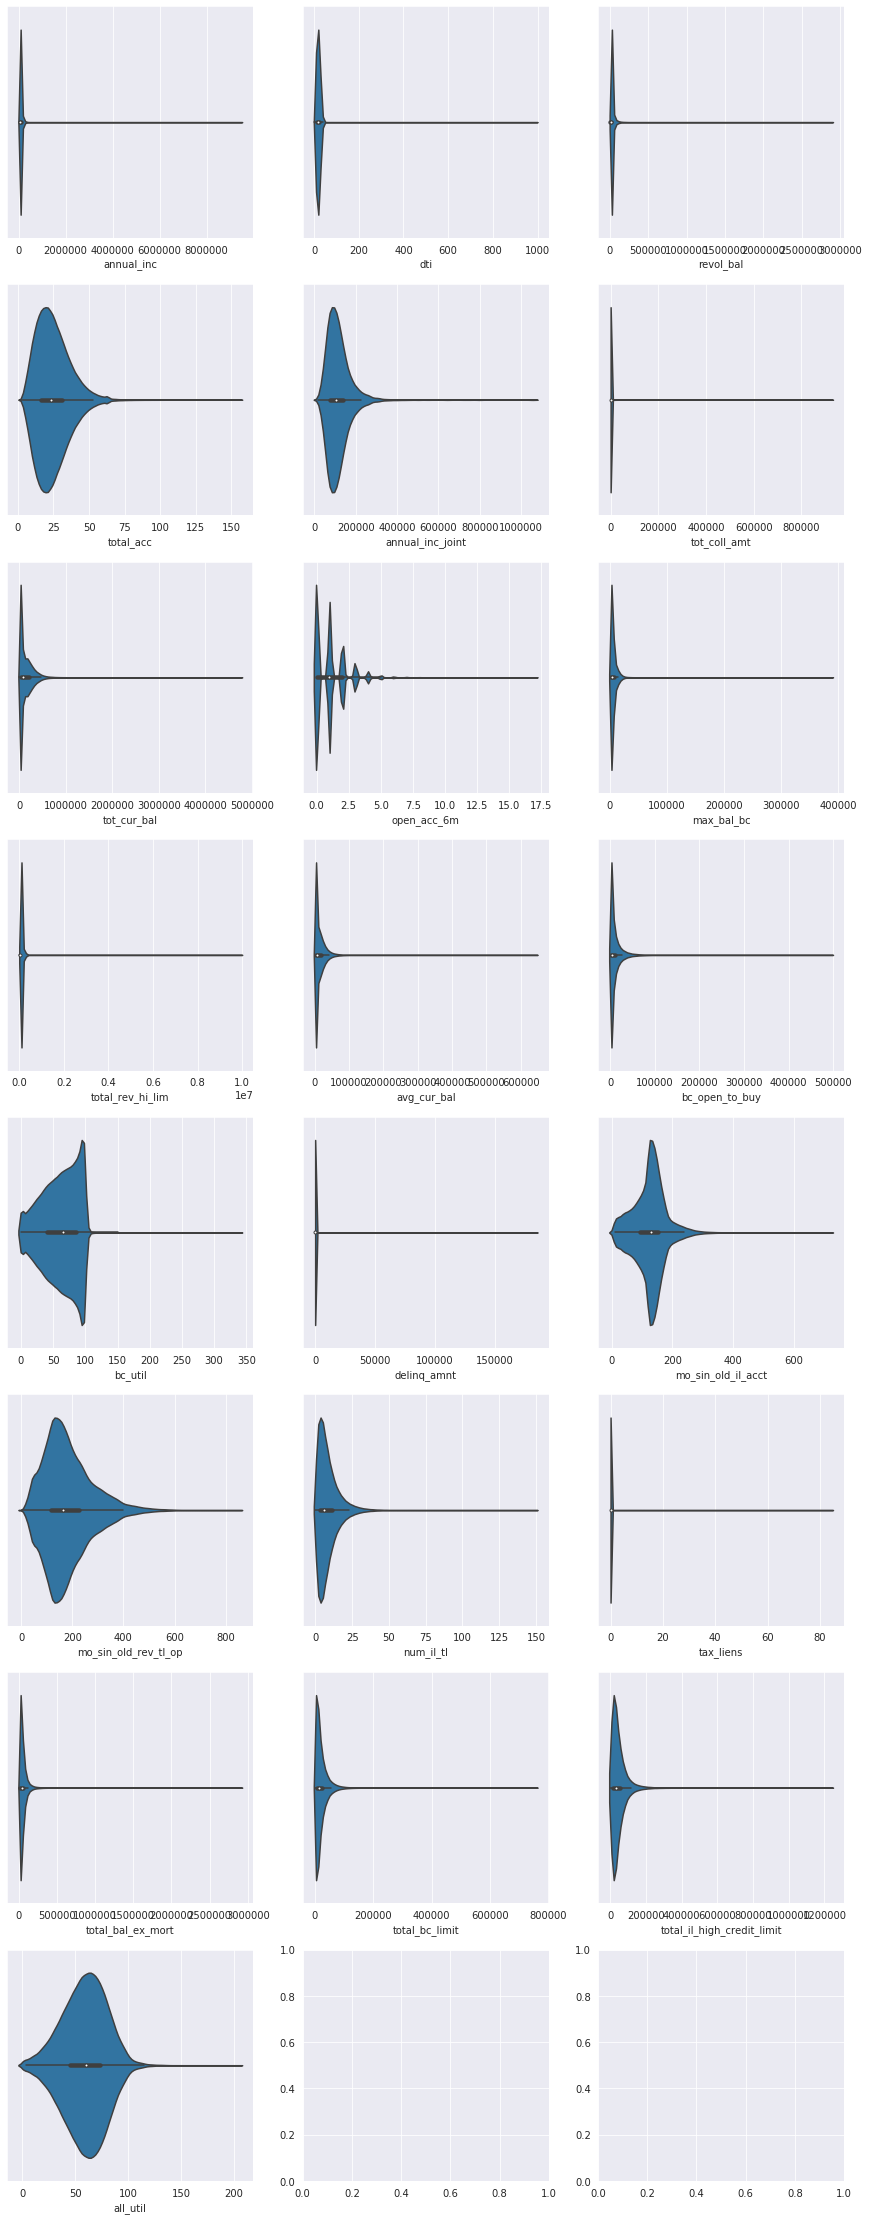

CPU times: user 34.2 s, sys: 9.88 s, total: 44.1 s
Wall time: 26.2 s


In [111]:
%%time
f, axes = plt.subplots(8, 3, figsize=(15, 40))

for i in range(len(col_with_high_max)):
    sns.violinplot(x = col_with_high_max[i], data = df, ax = axes[int(i/3),i%3])
    
plt.show()

In [112]:
df.loc[df.annual_inc.sort_values(ascending=False).index, :].head(20)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
697350,24000.0,60 months,7.89,485.38,0,5,10.0,MORTGAGE,9500000.0,Source Verified,2015-07-01,1,credit_card,0.12,0.0,1982-07-01,725.0,729.0,0.0,NaN,NaN,12.0,0.0,16854.0,22.0,31.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,256653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84200.0,NaN,NaN,NaN,4.0,21388.0,63855.0,22.9,0.0,0.0,102.0,395.0,8.0,8.0,6.0,8.0,NaN,4.0,NaN,0.0,5.0,7.0,7.0,14.0,6.0,10.0,19.0,7.0,12.0,0.0,0.0,0.0,2.0,100.0,42.9,0.0,0.0,347218.0,43834.0,80400.0,33318.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514318,12000.0,36 months,9.17,382.55,1,7,10.0,MORTGAGE,8500021.0,Source Verified,2015-11-01,0,credit_card,0.22,0.0,2001-09-01,660.0,664.0,0.0,48.0,NaN,9.0,0.0,18409.0,88.9,21.0,0.0,78.0,Individual,NaN,NaN,NaN,0.0,0.0,467240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000.0,NaN,NaN,NaN,5.0,51916.0,575.0,95.5,0.0,0.0,138.0,170.0,6.0,6.0,4.0,6.0,78.0,4.0,78.0,1.0,3.0,4.0,3.0,6.0,3.0,6.0,14.0,6.0,9.0,0.0,0.0,0.0,3.0,94.4,100.0,0.0,0.0,514111.0,44590.0,12900.0,39350.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1179218,30000.0,36 months,13.49,1017.92,2,12,2.0,RENT,8400000.0,Source Verified,2016-08-01,0,debt_consolidation,0.31,2.0,2001-08-01,660.0,664.0,0.0,18.0,NaN,7.0,0.0,2032.0,101.6,22.0,0.0,18.0,Individual,NaN,NaN,NaN,0.0,0.0,56713.0,0.0,4.0,0.0,1.0,23.0,54681.0,51.0,0.0,0.0,2032.0,53.0,2000.0,1.0,5.0,1.0,1.0,9452.0,0.0,101.6,0.0,0.0,162.0,158.0,39.0,23.0,1.0,47.0,NaN,3.0,NaN,3.0,1.0,1.0,1.0,5.0,12.0,2.0,7.0,1.0,7.0,0.0,0.0,2.0,0.0,86.4,100.0,0.0,0.0,93894.0,56713.0,2000.0,91894.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
552273,30000.0,36 months,12.69,1006.35,2,12,10.0,OWN,8253000.0,Source Verified,2015-11-01,0,debt_consolidation,0.14,0.0,2002-08-01,670.0,674.0,2.0,32.0,NaN,18.0,0.0,26402.0,61.5,26.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,130006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42900.0,NaN,NaN,NaN,7.0,7223.0,7407.0,66.2,0.0,0.0,155.0,158.0,1.0,1.0,1.0,6.0,NaN,0.0,NaN,0.0,9.0,15.0,10.0,12.0,1.0,17.0,24.0,15.0,18.0,0.0,0.0,0.0,6.0,96.2,30.0,0.0,0.0,170485.0,26402.0,21900.0,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1693681,10000.0,36 months,18.06,361.83,3,17,3.0,OWN,8000000.0,Source Verified,2017-11-01,0,debt_consolidation,0.21,1.0,1985-04-01,670.0,674.0,1.0,21.0,NaN,7.0,0.0,10433.0,90.7,36.0,0.0,21.0,Individual,NaN,NaN,NaN,0.0,0.0,31330.0,0.0,3.0,1.0,1.0,7.0,17396.0,39.0,0.0,1.0,5419.0,52.0,11500.0,1.0,1.0,2.0,2.0,44

In [125]:
df.loc[df.annual_inc.sort_values().index, :].head(20)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
1780049,10000.0,36 months,17.47,358.88,3,16,0.0,MORTGAGE,0.0,Not Verified,2018-03-01,0,other,NaN,0.0,2007-08-01,735.0,739.0,0.0,NaN,NaN,4.0,0.0,1560.0,0.188,4.0,0.0,NaN,Joint App,46000.0,20.82,Not Verified,0.0,0.0,31936.0,0.0,1.0,1.0,1.0,8.0,30376.0,92.0,0.0,2.0,1560.0,77.0,8300.0,0.0,0.0,3.0,3.0,10645.0,440.0,78.0,0.0,0.0,8.0,127.0,21.0,8.0,0.0,22.0,NaN,8.0,NaN,0.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,4.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,41438.0,31936.0,2000.0,33138.0,1560.0,680.0,684.0,2017-03-01,1.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,NaN
1502488,5000.0,36 months,14.99,173.31,2,14,0.0,RENT,0.0,Not Verified,2017-04-01,0,debt_consolidation,NaN,0.0,2007-03-01,685.0,689.0,0.0,NaN,58.0,12.0,1.0,5944.0,0.394,16.0,0.0,NaN,Joint App,42000.0,12.43,Not Verified,0.0,0.0,5944.0,1.0,0.0,0.0,0.0,NaN,0.0,NaN,3.0,8.0,1940.0,39.0,15100.0,0.0,0.0,0.0,8.0,495.0,2835.0,61.2,0.0,0.0,NaN,121.0,4.0,4.0,0.0,4.0,NaN,NaN,NaN,1.0,4.0,9.0,4.0,6.0,0.0,12.0,16.0,9.0,12.0,0.0,0.0,0.0,3.0,93.8,25.0,0.0,0.0,15100.0,5944.0,7300.0,0.0,5944.0,625.0,629.0,2005-06-01,0.0,0.0,1.0,NaN,1.0,1.0,0.0,0.0,NaN
1648222,17000.0,60 months,16.02,413.59,2,15,0.0,RENT,0.0,Not Verified,2017-12-01,1,debt_consolidation,NaN,0.0,2007-02-01,660.0,664.0,1.0,68.0,54.0,10.0,1.0,5393.0,0.240,34.0,0.0,68.0,Joint App,71000.0,18.15,Not Verified,0.0,0.0,5393.0,3.0,0.0,0.0,0.0,73.0,0.0,NaN,4.0,7.0,2670.0,24.0,22500.0,7.0,0.0,4.0,8.0,539.0,11030.0,19.5,0.0,0.0,121.0,130.0,2.0,2.0,1.0,4.0,68.0,2.0,68.0,2.0,1.0,5.0,3.0,15.0,3.0,10.0,30.0,5.0,10.0,0.0,0.0,0.0,4.0,91.7,33.3,1.0,0.0,22500.0,5393.0,13700.0,0.0,5394.0,670.0,674.0,2006-12-01,3.0,1.0,25.0,21.0,15.0,24.0,0.0,0.0,69.0
2089472,11000.0,36 months,18.94,402.89,3,17,0.0,RENT,0.0,Not Verified,2018-08-01,0,debt_consolidation,NaN,0.0,2002-05-01,660.0,664.0,0.0,31.0,NaN,5.0,0.0,9796.0,0.816,9.0,0.0,31.0,Joint App,39437.0,13.51,Not Verified,0.0,0.0,15781.0,0.0,1.0,1.0,1.0,7.0,5985.0,86.0,1.0,1.0,7809.0,83.0,12000.0,1.0,2.0,1.0,2.0,3156.0,204.0,98.0,0.0,0.0,113.0,69.0,9.0,7.0,2.0,9.0,NaN,7.0,NaN,1.0,2.0,2.0,2.0,2.0,3.0,4.0,4.0,2.0,5.0,0.0,0.0,0.0,2.0,88.9,100.0,0.0,0.0,19000.0,15781.0,10000.0,7000.0,16186.0,655.0,659.0,2002-05-01,0.0,2.0,5.0,93.6,1.0,4.0,0.0,0.0,31.0
1331153,24350.0,36 months,14.99,843.99,2,14,0.5,MORTGAGE,0.0,Not Verified,2017-03-01,0,debt_consolidation,NaN,0.0,2010-04-01,690.0,694.0,0.0,NaN,NaN,7.0,0.0,13150.0,0.981,11.0,0.0,NaN,Joint App,58000.0,28.30,Not Verified,0.0,0.0,148471.0,0.0,1.

**Notes**:
Both high and low income loans have fair share of health and unhealthy loans. Therefore, not outliers.

In [113]:
df.dti.sort_values(ascending = False).head(20)

1875347    999.00
1613473    999.00
1241516    999.00
1053410    999.00
1387019    999.00
1856956    999.00
1620983    991.57
1355372    886.77
1080058    822.00
2042319    769.40
1603271    765.76
1647005    502.41
1795269    460.21
1079881    398.40
532889     380.53
1888841    345.42
1560045    325.23
2062903    308.25
1468750    307.75
1585437    305.60
Name: dti, dtype: float64

In [114]:
df.loc[df.dti.sort_values(ascending = False).index, :].head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
1875347,24000.0,36 months,13.06,809.35,2,11,0.0,MORTGAGE,3000.0,Not Verified,2018-06-01,1,debt_consolidation,999.00,0.0,1998-10-01,730.0,734.0,0.0,NaN,NaN,19.0,0.0,53499.0,63.6,34.0,0.0,NaN,Joint App,243000.0,33.98,Not Verified,0.0,0.0,590131.0,1.0,6.0,1.0,1.0,1.0,140577.0,93.0,0.0,0.0,20180.0,82.0,84100.0,0.0,0.0,0.0,1.0,31060.0,1706.0,96.8,0.0,0.0,82.0,236.0,30.0,1.0,4.0,30.0,NaN,NaN,NaN,0.0,5.0,8.0,5.0,12.0,7.0,12.0,23.0,8.0,19.0,0.0,0.0,0.0,1.0,100.0,100.0,0.0,0.0,652771.0,194076.0,52800.0,151695.0,170257.0,690.0,694.0,1999-02-01,1.0,4.0,13.0,98.5,6.0,10.0,0.0,0.0,NaN
1613473,7000.0,36 months,7.35,217.27,0,4,0.0,MORTGAGE,1000.0,Not Verified,2017-07-01,0,credit_card,999.00,0.0,2004-01-01,750.0,754.0,1.0,NaN,NaN,14.0,0.0,16499.0,34.5,19.0,0.0,NaN,Joint App,113000.0,31.87,Not Verified,0.0,0.0,112938.0,4.0,3.0,0.0,1.0,19.0,64014.0,70.0,4.0,6.0,7124.0,52.0,47800.0,1.0,3.0,2.0,7.0,8688.0,11615.0,53.0,0.0,0.0,119.0,162.0,4.0,4.0,2.0,4.0,NaN,4.0,NaN,0.0,4.0,7.0,4.0,4.0,4.0,10.0,13.0,7.0,14.0,0.0,0.0,0.0,4.0,100.0,25.0,0.0,0.0,185833.0,80513.0,24700.0,95533.0,24381.0,715.0,719.0,2001-08-01,1.0,4.0,24.0,31.5,13.0,17.0,0.0,0.0,27.0
1241516,35000.0,36 months,21.49,1327.45,3,20,0.0,RENT,1000.0,Source Verified,2016-12-01,1,credit_card,999.00,0.0,2012-12-01,685.0,689.0,1.0,34.0,NaN,7.0,0.0,11793.0,64.1,8.0,0.0,NaN,Joint App,121000.0,12.67,Not Verified,0.0,0.0,33522.0,1.0,2.0,0.0,1.0,18.0,21729.0,51.0,1.0,2.0,6773.0,55.0,18400.0,0.0,0.0,2.0,3.0,4789.0,6788.0,53.2,0.0,0.0,41.0,47.0,2.0,2.0,0.0,2.0,NaN,2.0,NaN,0.0,2.0,3.0,3.0,3.0,3.0,5.0,5.0,3.0,7.0,0.0,0.0,0.0,1.0,87.5,33.3,0.0,0.0,60834.0,33522.0,14500.0,42434.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1053410,24000.0,36 months,9.16,764.99,1,7,0.0,MORTGAGE,600.0,Source Verified,2016-06-01,0,debt_consolidation,999.00,0.0,2000-08-01,680.0,684.0,0.0,NaN,NaN,16.0,0.0,24733.0,58.5,21.0,0.0,NaN,Joint App,150600.0,6.46,Not Verified,0.0,0.0,172432.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1.0,2.0,8254.0,59.0,42300.0,0.0,0.0,1.0,4.0,12317.0,9370.0,69.6,0.0,0.0,NaN,188.0,7.0,7.0,2.0,7.0,NaN,7.0,NaN,0.0,6.0,9.0,9.0,11.0,0.0,15.0,18.0,9.0,16.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,0.0,198200.0,24733.0,30800.0,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1387019,28000.0,36 months,11.49,923.20,1,10,0.0,MORTGAGE,400.0,Verified,2017-01-01,0,credit_card,999.00,0.0,2007-11-01,670.0,674.0,0.0,39.0,NaN,5.0,0.0,21788.0,96.8,21.0,0.0,NaN,Joint App,125400.0,17

In [115]:
df.loc[df.dti.sort_values().index, :].head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
1679910,16000.0,36 months,16.02,562.68,2,15,0.5,RENT,40000.0,Verified,2017-12-01,0,major_purchase,0.0,1.0,2012-12-01,695.0,699.0,0.0,14.0,NaN,2.0,0.0,0.0,0.0,5.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,131369.0,0.0,0.0,0.0,0.0,39.0,0.0,NaN,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,1.0,65685.0,1000.0,0.0,0.0,0.0,39.0,59.0,26.0,23.0,1.0,26.0,14.0,13.0,14.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,136000.0,0.0,1000.0,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1941232,21000.0,36 months,10.90,686.52,1,9,1.0,RENT,30000.0,Source Verified,2018-05-01,0,small_business,0.0,0.0,2011-09-01,765.0,769.0,0.0,NaN,NaN,8.0,0.0,0.0,0.0,13.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,30243.0,0.0,6.0,2.0,2.0,7.0,30243.0,97.0,0.0,1.0,0.0,69.0,12500.0,0.0,0.0,1.0,3.0,3780.0,12500.0,0.0,0.0,0.0,80.0,51.0,17.0,7.0,0.0,17.0,NaN,1.0,NaN,0.0,0.0,0.0,2.0,2.0,7.0,2.0,6.0,0.0,8.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,43714.0,30243.0,12500.0,31214.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380742,28500.0,60 months,16.29,697.47,3,17,10.0,MORTGAGE,57000.0,Source Verified,2014-05-01,0,major_purchase,0.0,0.0,1998-05-01,780.0,784.0,2.0,NaN,NaN,5.0,0.0,0.0,0.0,17.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,86647.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33000.0,NaN,NaN,NaN,0.0,21662.0,28000.0,0.0,0.0,0.0,88.0,177.0,34.0,34.0,4.0,49.0,NaN,3.0,NaN,0.0,0.0,0.0,2.0,6.0,2.0,4.0,11.0,0.0,5.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,129000.0,0.0,28000.0,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20303,1500.0,36 months,11.11,49.19,1,10,4.0,RENT,28452.0,Verified,2011-01-01,0,other,0.0,0.0,2004-01-01,685.0,689.0,1.0,35.0,NaN,11.0,0.0,0.0,0.0,20.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1769915,8400.0,36 months,11.98,278.92,1,10,4.0,RENT,30000.0,Source Verified,2018-03-01,0,medical,0.0,0.0,2010-09-01,760.0,764.0,1.0,NaN,NaN,1.0,0.0,0.0,0.0,3.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,90.0,0.0,NaN,1.0,1.0,0.0,0.0,500.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,0.0,90.0,36.0,5.0,5.0,0.0,NaN,NaN,5.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,100.0,NaN,0.0,0.0,500.0,0.0,0.0,0.0,NaN,NaN,NaN,NaT,NaN,NaN,N

**Notes**:
Both high and low dti loans have fair share of health and unhealthy loans. Therefore, not outliers.

In [116]:
df.tot_coll_amt.sort_values(ascending = False).head(20)

1417288    932461.0
1724696    309838.0
701395     227157.0
938950     197765.0
969522     173380.0
1384217    173380.0
507888     169257.0
780521     143558.0
239294     124825.0
2097796    120090.0
1021125    119428.0
258072     119428.0
1744407    114407.0
885728     113384.0
1424594    102016.0
1159890     99950.0
1175341     96747.0
461839      95806.0
577486      93599.0
916546      92527.0
Name: tot_coll_amt, dtype: float64

In [117]:
df.loc[df.tot_coll_amt.sort_values(ascending = False).index, :].head(10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
1417288,13000.0,36 months,11.49,428.63,1,10,8.0,RENT,150000.0,Not Verified,2017-01-01,0,credit_card,6.46,0.0,2003-07-01,665.0,669.0,1.0,NaN,53.0,8.0,3.0,14349.0,45.6,11.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,932461.0,30646.0,2.0,1.0,1.0,1.0,9.0,16297.0,81.0,2.0,3.0,10036.0,59.0,31500.0,2.0,0.0,3.0,4.0,3831.0,3835.0,77.0,0.0,0.0,9.0,161.0,2.0,2.0,2.0,5.0,NaN,2.0,NaN,0.0,3.0,5.0,3.0,3.0,1.0,7.0,8.0,5.0,8.0,0.0,0.0,0.0,3.0,100.0,66.7,2.0,1.0,51558.0,30646.0,16700.0,20058.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1724696,21000.0,36 months,17.09,749.65,3,16,5.0,MORTGAGE,13932.0,Verified,2017-11-01,0,debt_consolidation,155.73,0.0,2009-12-01,675.0,679.0,1.0,NaN,NaN,15.0,0.0,4810.0,30.1,21.0,0.0,NaN,Joint App,93932.0,29.42,Verified,0.0,309838.0,42679.0,1.0,5.0,0.0,6.0,15.0,37869.0,71.0,1.0,6.0,1236.0,62.0,16000.0,2.0,1.0,2.0,12.0,2845.0,4740.0,40.8,0.0,0.0,49.0,67.0,2.0,2.0,0.0,2.0,NaN,0.0,NaN,0.0,3.0,8.0,3.0,3.0,9.0,10.0,11.0,8.0,15.0,0.0,0.0,0.0,1.0,100.0,33.3,0.0,0.0,69348.0,42679.0,8000.0,53348.0,12275.0,620.0,624.0,2011-06-01,0.0,0.0,8.0,50.9,2.0,7.0,0.0,1.0,13.0
701395,24000.0,60 months,11.53,528.19,1,10,10.0,MORTGAGE,120000.0,Source Verified,2015-07-01,0,debt_consolidation,20.17,0.0,1992-05-01,670.0,674.0,0.0,70.0,70.0,13.0,1.0,13714.0,63.2,41.0,0.0,70.0,Individual,NaN,NaN,NaN,0.0,227157.0,71911.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23800.0,NaN,NaN,NaN,5.0,5993.0,5892.0,65.5,0.0,0.0,185.0,277.0,17.0,17.0,5.0,20.0,70.0,1.0,70.0,1.0,5.0,6.0,5.0,14.0,8.0,9.0,27.0,6.0,13.0,0.0,0.0,0.0,0.0,96.0,0.0,1.0,0.0,104304.0,71911.0,17100.0,80504.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938950,9050.0,36 months,11.99,300.55,2,11,0.5,RENT,40000.0,Source Verified,2016-03-01,1,credit_card,22.25,0.0,1986-09-01,665.0,669.0,0.0,73.0,NaN,10.0,0.0,4011.0,36.5,20.0,0.0,73.0,Individual,NaN,NaN,NaN,0.0,197765.0,155036.0,0.0,4.0,0.0,2.0,15.0,151025.0,93.0,3.0,5.0,1877.0,85.0,11000.0,1.0,3.0,1.0,7.0,15504.0,3015.0,45.2,0.0,0.0,353.0,102.0,9.0,9.0,0.0,9.0,NaN,11.0,NaN,2.0,2.0,4.0,3.0,3.0,14.0,6.0,6.0,4.0,10.0,0.0,0.0,0.0,3.0,89.5,33.3,0.0,0.0,166152.0,155036.0,5500.0,155152.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
969522,16000.0,36 months,9.75,514.40,1,8,3.0,MORTGAGE,110000.0,Not Verified,2016-02-01,0,home_improvement,15.64,0.0,1996-07-01,675.0,679.0,0.0,33.0,NaN,20.0,0.0,10482.0,39.3,47.0,0.0,51.0,Individual,NaN,NaN,NaN,0.0,173380.0,292678.0,0.0,8.0,0.0,1.0,13.0,20

**Notes**:
High total collection amount loans has fair share of health and unhealthy loans. Therefore, not outliers.

In [118]:
df.tot_cur_bal.sort_values(ascending = False).head(20)

177987     4772549.0
755798     4447397.0
234487     4026405.0
130027     3881449.0
301406     3840795.0
252412     3796811.0
1412570    3777206.0
648633     3726495.0
1316346    3701271.0
232259     3610743.0
178321     3471522.0
1411805    3449529.0
60588      3437283.0
345869     3258254.0
1244386    3254633.0
596107     3182645.0
574353     3164353.0
994025     3080029.0
162295     2940054.0
882994     2917766.0
Name: tot_cur_bal, dtype: float64

In [119]:
def examine_col(col, head = 10):
    return df.loc[df[col].sort_values(ascending = False).index, :].head(head)

In [120]:
examine_col('tot_cur_bal')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
177987,35000.0,36 months,15.80,1227.05,2,13,2.0,MORTGAGE,800000.0,Source Verified,2013-01-01,0,credit_card,4.12,0.0,1990-03-01,680.0,684.0,3.0,28.0,NaN,12.0,0.0,54511.0,87.4,14.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,4772549.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62404.0,NaN,NaN,NaN,8.0,477255.0,7893.0,87.4,0.0,0.0,36.0,139.0,3.0,3.0,1.0,3.0,NaN,3.0,28.0,0.0,6.0,6.0,8.0,9.0,1.0,9.0,11.0,6.0,12.0,0.0,0.0,0.0,4.0,92.0,71.4,0.0,0.0,4932524.0,116117.0,62404.0,30114.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
755798,35000.0,36 months,16.55,1240.03,3,17,10.0,OWN,400000.0,Verified,2015-06-01,0,moving,24.83,0.0,1996-09-01,740.0,744.0,0.0,NaN,68.0,9.0,1.0,2904836.0,37.4,17.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,4447397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999999.0,NaN,NaN,NaN,3.0,555925.0,15109.0,37.0,0.0,0.0,111.0,200.0,6.0,6.0,3.0,6.0,NaN,NaN,NaN,0.0,3.0,5.0,3.0,3.0,7.0,6.0,7.0,5.0,9.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,9999999.0,2921551.0,24000.0,28655.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234487,35000.0,36 months,12.39,1169.04,2,11,10.0,MORTGAGE,1100000.0,Verified,2014-12-01,0,debt_consolidation,31.39,3.0,1988-04-01,665.0,669.0,0.0,1.0,NaN,9.0,0.0,128554.0,98.0,25.0,0.0,NaN,Individual,NaN,NaN,NaN,1.0,0.0,4026405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135000.0,NaN,NaN,NaN,1.0,447378.0,5751.0,NaN,0.0,9751.0,137.0,263.0,70.0,23.0,3.0,263.0,NaN,NaN,NaN,0.0,1.0,3.0,1.0,3.0,10.0,3.0,11.0,3.0,8.0,0.0,1.0,0.0,0.0,88.0,100.0,0.0,0.0,5022617.0,500404.0,100000.0,649004.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130027,28000.0,36 months,8.90,889.09,0,5,1.0,MORTGAGE,1000000.0,Verified,2013-06-01,0,credit_card,12.54,0.0,1986-06-01,725.0,729.0,2.0,39.0,NaN,13.0,0.0,2568995.0,20.4,28.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,3881449.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999999.0,NaN,NaN,NaN,1.0,298573.0,8288.0,62.5,0.0,0.0,122.0,319.0,33.0,2.0,6.0,69.0,NaN,2.0,NaN,0.0,4.0,7.0,4.0,7.0,8.0,8.0,13.0,7.0,13.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,0.0,9999999.0,2644442.0,140200.0,17987.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301406,26200.0,36 months,7.69,817.28,0,4,3.0,MORTGAGE,999999.0,Verified,2014-10-01,0,debt_consolidation,13.30,0.0,1986-02-01,720.0,724.0,0.0,54.0,NaN,16.0,0.0,2560703.0,16.3,31.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,3840795.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999999.0,NaN,NaN,NaN,5.0,240050.0,2

In [121]:
df.delinq_amnt.sort_values(ascending = False).head()

1278487    185408.0
1573742     92051.0
800794      86399.0
674832      72242.0
742933      66497.0
Name: delinq_amnt, dtype: float64

In [122]:
examine_col('delinq_amnt')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
1278487,35000.0,36 months,13.49,1187.57,2,12,10.0,MORTGAGE,120000.0,Verified,2016-11-01,0,debt_consolidation,13.14,2.0,1994-12-01,670.0,674.0,0.0,6.0,NaN,23.0,0.0,205946.0,76.0,48.0,0.0,1.0,Individual,NaN,NaN,NaN,1.0,0.0,694619.0,0.0,1.0,0.0,1.0,15.0,23202.0,75.0,2.0,3.0,9158.0,76.0,270050.0,0.0,1.0,2.0,4.0,34730.0,9114.0,29.0,0.0,185408.0,112.0,263.0,12.0,12.0,5.0,12.0,NaN,9.0,1.0,1.0,7.0,17.0,19.0,19.0,3.0,17.0,42.0,10.0,19.0,NaN,0.0,1.0,2.0,88.0,14.3,0.0,0.0,868285.0,42911.0,63800.0,30935.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1573742,12500.0,36 months,15.05,433.63,2,14,10.0,RENT,79000.0,Verified,2017-08-01,0,debt_consolidation,24.19,3.0,2004-04-01,660.0,664.0,0.0,2.0,NaN,15.0,0.0,2326.0,15.3,27.0,0.0,2.0,Individual,NaN,NaN,NaN,2.0,0.0,530723.0,1.0,4.0,1.0,3.0,12.0,56720.0,67.0,1.0,1.0,744.0,53.0,15200.0,2.0,2.0,1.0,4.0,40825.0,356.0,67.6,0.0,92051.0,148.0,160.0,5.0,5.0,4.0,5.0,NaN,12.0,NaN,2.0,1.0,5.0,1.0,2.0,9.0,8.0,14.0,5.0,13.0,2.0,0.0,2.0,2.0,84.6,0.0,0.0,0.0,599542.0,59046.0,1100.0,79342.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
800794,9125.0,36 months,15.61,319.06,3,16,10.0,RENT,90000.0,Verified,2015-03-01,0,credit_card,10.11,9.0,1994-07-01,670.0,674.0,4.0,22.0,56.0,13.0,1.0,8090.0,42.0,56.0,0.0,1.0,Individual,NaN,NaN,NaN,1.0,0.0,226422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19400.0,NaN,NaN,NaN,9.0,20583.0,2383.0,80.0,0.0,86399.0,132.0,248.0,5.0,5.0,7.0,5.0,NaN,0.0,75.0,1.0,3.0,9.0,14.0,19.0,9.0,9.0,40.0,9.0,10.0,NaN,0.0,8.0,4.0,73.0,66.7,1.0,0.0,242579.0,17295.0,7150.0,10000.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
674832,10000.0,36 months,12.69,335.45,2,12,10.0,MORTGAGE,110000.0,Source Verified,2015-07-01,0,debt_consolidation,10.92,1.0,1991-06-01,680.0,684.0,5.0,NaN,46.0,14.0,1.0,9557.0,57.0,48.0,0.0,1.0,Individual,NaN,NaN,NaN,1.0,0.0,346921.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16850.0,NaN,NaN,NaN,9.0,28910.0,2775.0,72.0,0.0,72242.0,130.0,289.0,3.0,3.0,3.0,3.0,NaN,1.0,NaN,1.0,5.0,9.0,18.0,20.0,7.0,9.0,39.0,8.0,11.0,NaN,0.0,1.0,8.0,83.0,25.0,1.0,0.0,369915.0,47370.0,11100.0,40283.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742933,23700.0,36 months,17.57,851.71,3,19,7.0,RENT,56000.0,Verified,2015-05-01,1,debt_consolidation,23.04,2.0,1991-11-01,690.0,694.0,5.0,NaN,53.0,22.0,1.0,10005.0,30.0,58.0,0.0,2.0,Individual,NaN,NaN,NaN,1.0,0.0,229753.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33090.0,NaN,NaN,NaN

In [123]:
examine_col('tax_liens', 20)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verified_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
534976,6400.0,36 months,13.18,216.20,2,13,1.0,MORTGAGE,38000.0,Verified,2015-11-01,1,debt_consolidation,32.41,0.0,1987-12-01,670.0,674.0,3.0,40.0,19.0,13.0,86.0,7788.0,78.7,19.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,51.0,61402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9900.0,NaN,NaN,NaN,6.0,4723.0,1094.0,70.4,0.0,0.0,335.0,81.0,3.0,3.0,0.0,47.0,NaN,3.0,NaN,0.0,3.0,5.0,3.0,4.0,13.0,5.0,6.0,5.0,13.0,0.0,0.0,0.0,5.0,94.7,33.3,1.0,85.0,72880.0,61402.0,3700.0,62980.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1217139,7000.0,36 months,8.99,222.57,1,6,5.0,OWN,35000.0,Source Verified,2016-07-01,1,debt_consolidation,16.36,0.0,2006-04-01,700.0,704.0,0.0,NaN,63.0,9.0,61.0,6753.0,34.8,14.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,18118.0,1.0,1.0,1.0,1.0,8.0,11365.0,88.0,1.0,5.0,2763.0,56.0,19400.0,0.0,0.0,2.0,6.0,2013.0,12328.0,33.4,0.0,0.0,58.0,122.0,5.0,5.0,0.0,5.0,NaN,8.0,NaN,0.0,7.0,8.0,7.0,9.0,4.0,8.0,10.0,8.0,9.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,61.0,32347.0,18118.0,18500.0,12947.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132829,10000.0,36 months,15.31,348.18,2,12,3.0,RENT,38750.0,Source Verified,2013-06-01,0,credit_card,21.99,0.0,1988-01-01,675.0,679.0,1.0,NaN,23.0,15.0,54.0,10056.0,43.3,31.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,30978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23200.0,NaN,NaN,NaN,4.0,2213.0,5254.0,59.6,0.0,0.0,186.0,304.0,10.0,10.0,2.0,55.0,NaN,1.0,NaN,0.0,7.0,10.0,8.0,12.0,7.0,13.0,17.0,10.0,15.0,0.0,0.0,0.0,2.0,100.0,14.3,1.0,53.0,46763.0,30978.0,13000.0,23563.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
782349,4450.0,36 months,14.65,153.50,2,15,1.0,RENT,126000.0,Not Verified,2015-04-01,0,debt_consolidation,8.57,0.0,1986-04-01,660.0,664.0,2.0,NaN,37.0,7.0,49.0,3740.0,55.8,15.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,3461.0,32031.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6700.0,NaN,NaN,NaN,5.0,4576.0,273.0,90.2,0.0,0.0,168.0,348.0,5.0,5.0,0.0,9.0,NaN,5.0,NaN,0.0,3.0,4.0,3.0,4.0,5.0,5.0,10.0,4.0,7.0,0.0,0.0,0.0,3.0,100.0,100.0,3.0,46.0,43506.0,32031.0,2800.0,36806.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1645610,8500.0,36 months,16.02,298.92,2,15,10.0,RENT,176000.0,Not Verified,2017-07-01,1,other,5.28,0.0,1992-12-01,690.0,694.0,3.0,72.0,48.0,9.0,44.0,15991.0,52.6,18.0,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,24974.0,3.0,1.0,1.0,1.0,11.0,8983.0,75.0,2.0,4.0,8933.0,59.0,30400.0,2.0,0.0,4.0,6.0,2775.0,5948.0,70.4,0.0,0.0,148.0,294

**Notes: Examination of extreme values shows no particular indicator of being outliers.**

[back to top](#toc)

<a id = 'miss'></a>
#### 1.D. Missing values
##### 1.D.a. Categorical features

In [124]:
df.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64'), dtype('<M8[ns]')],
      dtype=object)

In [125]:
cat_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
print(len(cat_cols))
cat_cols

6


['term',
 'home_ownership',
 'is_inc_v',
 'purpose',
 'application_type',
 'verified_status_joint']

In [126]:
df[cat_cols].describe().transpose()

,count,unique,top,freq
term,545714,2,36 months,470841
home_ownership,545714,4,MORTGAGE,261645
is_inc_v,545714,3,Source Verified,196789
purpose,545714,14,debt_consolidation,312980
application_type,545714,2,Individual,538558
verified_status_joint,7072,3,Not Verified,4063


In [127]:
df.loc[:, cat_cols] = df[cat_cols].fillna('Missing')
df[cat_cols].isnull().sum()

term                     0
home_ownership           0
is_inc_v                 0
purpose                  0
application_type         0
verified_status_joint    0
dtype: int64

In [128]:
for col in cat_cols:
    print (df.groupby(col)['loan_status'].agg(['count', 'mean']), '\n')

             count      mean
term                        
 36 months  470841  0.153954
 60 months   74873  0.252641 

                 count      mean
home_ownership                  
ANY                286  0.157343
MORTGAGE        261645  0.144444
OWN              56111  0.175973
RENT            227672  0.191908 

                  count      mean
is_inc_v                         
Not Verified     174823  0.135657
Source Verified  196789  0.177906
Verified         174102  0.187695 

                     count      mean
purpose                             
car                   6955  0.127822
credit_card         120491  0.149696
debt_consolidation  312980  0.175302
educational            307  0.159609
home_improvement     33750  0.149778
house                 2675  0.164860
major_purchase       12668  0.145327
medical               6431  0.180998
moving                4046  0.186110
other                32398  0.176462
renewable_energy       434  0.193548
small_business        6691  0

In [129]:
le = LabelEncoder()
for col in cat_cols:
    print (col)
    col = le.fit_transform(df[col])
    print (chi2(np.array(col).reshape(-1,1), df.loan_status), 
           '\n======\n')

term
(array([3892.91298387]), array([0.])) 

home_ownership
(array([912.29258902]), array([2.08727462e-200])) 

is_inc_v
(array([1085.56984867]), array([4.52079206e-238])) 

purpose
(array([220.40819982]), array([7.36792454e-50])) 

application_type
(array([169.62633698]), array([8.92850469e-39])) 

verified_status_joint
(array([406.65687173]), array([1.95815388e-90])) 



**Notes: All categorical features appear to be NOT independent with the target variable, indicating they are good features to include in our model.**

[back to 1.D. Missing values](#miss)

[back to top](#toc)

<a id = 'm-num'></a>
##### 1.D.b. Numerical features

In [130]:
num_cols = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.tolist()
print(len(num_cols))

91


In [131]:
# numerical features with missing values
num_cols_missing = df[num_cols].isnull().any()[df[num_cols].isnull().any()].index
len(num_cols_missing)

73

In [132]:
# check whether there are empty columns
df[num_cols].isnull().all().sum()

0

In [133]:
df.shape

(545714, 100)

In [134]:
df[num_cols_missing].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dti,545598.0,17.816211,9.754620,0.0,11.490,17.24,23.530,999.00
mths_since_last_delinq,263089.0,34.381168,21.857493,0.0,16.000,31.00,50.000,188.00
mths_since_last_record,86305.0,71.424610,27.595234,0.0,53.000,72.00,93.000,129.00
revol_util,545354.0,52.870967,24.280964,0.0,35.000,53.70,71.600,892.30
collections_12_mths_ex_med,545663.0,0.014890,0.138520,0.0,0.000,0.00,0.000,20.00
mths_since_last_major_derog,132959.0,43.315413,21.307671,0.0,26.000,43.00,61.000,188.00
annual_inc_joint,7156.0,113989.243844,59832.203828,18000.0,76000.000,103500.00,137000.000,1060000.00
dti_joint,7155.0,18.782327,7.772362,0.0,13.055,18.39,24.045,46.52
tot_coll_amt,484828.0,223.529516,2278.965491,0.0,0.000,0.00,0.000,932461.00
tot_cur_bal,484828.0,133861.592546,153330.272302,0.0,27081.750,71754.00,200037.000,4772549.00


[back to top](#toc)

<a id = 'sparse'></a>
**1.D.b.i. Drop sparse columns:**

Most sparse columns are joint applicant credibility information. Since joint applications account for only ~1% of the total loans, and we still have the main applicant's credit information, we will drop these for now.

In [135]:
num_cols_missing_sparse = df[num_cols_missing].notnull().sum()[df[num_cols_missing].notnull().sum() < 10000].index
len(num_cols_missing_sparse)

14

In [136]:
num_cols_missing_sparse

Index(['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
       'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog'],
      dtype='object')

In [137]:
df = df.drop(num_cols_missing_sparse, axis = 1)
df.shape

(545714, 86)

[back to top](#toc)

<a id = 'reason'></a>
**1.D.b.ii. Investigate reasons for missing values:**

In [138]:
num_cols = df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index.tolist()
print(len(num_cols))

77


In [139]:
num_cols_miss = df[num_cols].isnull().any()[df[num_cols].isnull().any()].index
len(num_cols_miss)

59

In [140]:
df[num_cols_miss].isnull().sum().sort_values(ascending = False)

mths_since_last_record            459409
mths_since_recent_bc_dlq          423784
mths_since_last_major_derog       412755
il_util                           412664
mths_since_rcnt_il                395884
all_util                          390990
max_bal_bc                        390970
open_rv_24m                       390970
inq_fi                            390970
open_il_24m                       390970
total_bal_il                      390970
open_il_12m                       390970
open_act_il                       390970
open_rv_12m                       390970
total_cu_tl                       390970
inq_last_12m                      390970
open_acc_6m                       390970
mths_since_recent_revol_delinq    372399
mths_since_last_delinq            282625
mths_since_recent_inq              94197
num_tl_120dpd_2m                   77581
mo_sin_old_il_acct                 77101
pct_tl_nvr_dlq                     60989
avg_cur_bal                        60897
num_rev_accts   

In [141]:
((sorted(df.loc[df['num_il_tl'].isnull(), :].issue_d.unique())[-2:])==
(sorted(df.loc[df['num_il_tl'].notnull(), :].issue_d.unique())[:2]))

True

In [142]:
# When varaibles were missing because they were not made available by the platform prior to certain date,
# loans issued without such features and with them overlap by 2 months. This is because each loan has 30 days to be funded before being issued.
# As a result, when a feature become available, loans that are already in the funding phase will be missing the feature while new loans issued 
# will contain the feature, even though, they are all issued in the same month

# The following analysis shows the existence of these features. However, such features can be missing still after
# becoming avaible due to other reasons that could also be informational. Therefore, the analysis will miss catching
# some features due to their failure to meet the overlapping by two months criteria mentioned above.

# It also asks different imputing strategy for prior to and after features are available.

%%time
num_cols_miss_time = []
for col in num_cols:
    if ((sorted(df.loc[df[col].isnull(), :].issue_d.unique())[-2:])==
        (sorted(df.loc[df[col].notnull(), :].issue_d.unique())[:2])):
        num_cols_miss_time.append([col, (sorted(df.loc[df[col].isnull(), :].issue_d.unique())[-2:])])
        print (col, ': ', sorted(df.loc[df[col].isnull(), :].issue_d.unique())[-2:], '\n')
       

tot_coll_amt :  [numpy.datetime64('2012-08-01T00:00:00.000000000'), numpy.datetime64('2012-09-01T00:00:00.000000000')] 

tot_cur_bal :  [numpy.datetime64('2012-08-01T00:00:00.000000000'), numpy.datetime64('2012-09-01T00:00:00.000000000')] 

open_acc_6m :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

open_act_il :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

open_il_12m :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

open_il_24m :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

total_bal_il :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

open_rv_12m :  [numpy.datetime64('2015-12-01T00:00:00.000000000'), numpy.datetime64('2016-01-01T00:00:00.000000000')] 

open_rv_24m :  [numpy.datetime64('2015

In [143]:
num_cols_miss_time.sort(key = lambda x: x[1][0])
num_cols_miss_time

[['acc_open_past_24mths',
  [numpy.datetime64('2012-03-01T00:00:00.000000000'),
   numpy.datetime64('2012-04-01T00:00:00.000000000')]],
 ['mort_acc',
  [numpy.datetime64('2012-03-01T00:00:00.000000000'),
   numpy.datetime64('2012-04-01T00:00:00.000000000')]],
 ['total_bal_ex_mort',
  [numpy.datetime64('2012-03-01T00:00:00.000000000'),
   numpy.datetime64('2012-04-01T00:00:00.000000000')]],
 ['total_bc_limit',
  [numpy.datetime64('2012-03-01T00:00:00.000000000'),
   numpy.datetime64('2012-04-01T00:00:00.000000000')]],
 ['num_bc_sats',
  [numpy.datetime64('2012-06-01T00:00:00.000000000'),
   numpy.datetime64('2012-07-01T00:00:00.000000000')]],
 ['num_sats',
  [numpy.datetime64('2012-06-01T00:00:00.000000000'),
   numpy.datetime64('2012-07-01T00:00:00.000000000')]],
 ['tot_coll_amt',
  [numpy.datetime64('2012-08-01T00:00:00.000000000'),
   numpy.datetime64('2012-09-01T00:00:00.000000000')]],
 ['tot_cur_bal',
  [numpy.datetime64('2012-08-01T00:00:00.000000000'),
   numpy.datetime64('2012-0

**Notes:**

Some features have missing values due to more than one reason: they were not available prior to certain date because the platform has not included them in the loan information. After they become availabe, missing value reason will depend on the features.

Therefore, the best way to deal with these features:
1. Find out the date when these features become available.
2. Prior to the date when these features become available to loans, flag them as 'NA', and fill them with either mode or mean whichever makes sense to the specific features;
3. After the date, missing values will be flaged as 'Missing', and filled with extreme, mean, mode, small, or whatever number makes sense to the specific features.

However, due to the constraint on time and resource, I will simply flag them as 'Missing' and impute with heuristics and see how our model performs on the biased imputation.


[back to top](#toc)

<a id = 'impute'></a>
#### 1.D.b.iii. impute numerical missing values

In [144]:
df.shape

(545714, 86)

In [145]:
len(num_cols_miss)

59

In [146]:
df[num_cols_miss].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dti,545598.0,17.816211,9.754620,0.0,11.49,17.24,23.53,999.0
mths_since_last_delinq,263089.0,34.381168,21.857493,0.0,16.00,31.00,50.00,188.0
mths_since_last_record,86305.0,71.424610,27.595234,0.0,53.00,72.00,93.00,129.0
revol_util,545354.0,52.870967,24.280964,0.0,35.00,53.70,71.60,892.3
collections_12_mths_ex_med,545663.0,0.014890,0.138520,0.0,0.00,0.00,0.00,20.0
mths_since_last_major_derog,132959.0,43.315413,21.307671,0.0,26.00,43.00,61.00,188.0
tot_coll_amt,484828.0,223.529516,2278.965491,0.0,0.00,0.00,0.00,932461.0
tot_cur_bal,484828.0,133861.592546,153330.272302,0.0,27081.75,71754.00,200037.00,4772549.0
open_acc_6m,154744.0,1.023594,1.197960,0.0,0.00,1.00,2.00,17.0
open_act_il,154744.0,2.761173,3.030269,0.0,1.00,2.00,3.00,48.0


**Imputing num_cols with missing values:**

1. **Missing NOT at random (due to absence of adverse events, e.g. no delinquency, derogatory), impute with a large number as missing is good, and large number is good 100yr*12mo/yr = 1200:** 
'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 


2. **Missing due to unavailability and/or random, fill with median:**
'dti', 'revol_util', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'

In [147]:
num_cols_miss_median = ['dti', 'revol_util', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']
len(num_cols_miss_median)

54

In [148]:
num_cols_miss_1200 = ['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog','mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']
len(num_cols_miss_1200)

5

In [151]:
for col in num_cols_miss:
    df.loc[:, col+'_mflag'] = df[col].isnull()    

In [152]:
df.shape

(545714, 145)

In [153]:
for col in num_cols_miss_1200:
    df.loc[:, col] = df[col].fillna(1200)

In [154]:
df[num_cols_miss_1200].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mths_since_last_delinq,545714.0,638.054562,582.634066,0.0,32.0,1200.0,1200.0,1200.0
mths_since_last_record,545714.0,1021.515118,411.943604,0.0,1200.0,1200.0,1200.0,1200.0
mths_since_last_major_derog,545714.0,918.182737,496.652579,0.0,1200.0,1200.0,1200.0,1200.0
mths_since_recent_bc_dlq,545714.0,940.780227,483.382553,0.0,1200.0,1200.0,1200.0,1200.0
mths_since_recent_revol_delinq,545714.0,830.276513,542.101247,0.0,57.0,1200.0,1200.0,1200.0


In [155]:
num_cols_miss_median_values = df[num_cols_miss_median].median()
num_cols_miss_median_values

dti                               17.24
revol_util                        53.70
collections_12_mths_ex_med         0.00
tot_coll_amt                       0.00
tot_cur_bal                    71754.00
open_acc_6m                        1.00
open_act_il                        2.00
open_il_12m                        0.00
open_il_24m                        1.00
mths_since_rcnt_il                12.00
total_bal_il                   22357.00
il_util                           74.00
open_rv_12m                        1.00
open_rv_24m                        2.00
max_bal_bc                      3937.00
all_util                          60.00
total_rev_hi_lim               22800.00
inq_fi                             1.00
total_cu_tl                        0.00
inq_last_12m                       2.00
acc_open_past_24mths               4.00
avg_cur_bal                     6820.00
bc_open_to_buy                  4180.00
bc_util                           65.50
chargeoff_within_12_mths           0.00


In [156]:
num_cols_miss_imputing_dict = {'num_cols_miss_median': num_cols_miss_median,
                         'num_cols_miss': num_cols_miss,
                         'num_cols_miss_1200': num_cols_miss_1200,
                         'num_cols_miss_median_values': num_cols_miss_median_values,
                         'num_cols_miss_sparse': num_cols_missing_sparse}

In [157]:
print(len(num_cols_missing_sparse), 
      len(num_cols_miss),
      len(num_cols_miss_1200), 
      len(num_cols_miss_median),
      len(num_cols_miss_median_values))

14 59 5 54 54


[back to top](#toc)

<a id = 'save'></a>
**1.D.b.i. save imputing information for future use:**

In [158]:
import pickle

In [159]:
with open ('num_cols_miss_imputing_dict.pkl', 'wb') as f:
    pickle.dump(num_cols_miss_imputing_dict, f)

In [160]:
with open('num_cols_miss_imputing_dict.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [161]:
for k, v in test_dict.items():
    print (k, len(v))

num_cols_miss_median 54
num_cols_miss 59
num_cols_miss_1200 5
num_cols_miss_median_values 54
num_cols_miss_sparse 14


In [162]:
# impute numerical features with missing value
%%time
for col in num_cols_miss_median:
    df.loc[:, col] = df[col].fillna(df[col].median())

CPU times: user 588 ms, sys: 0 ns, total: 588 ms
Wall time: 587 ms


In [163]:
df.isnull().sum()

loan_amnt                                    0
term                                         0
int_rate                                     0
installment                                  0
grade                                        0
sub_grade                                    0
emp_length                                   0
home_ownership                               0
annual_inc                                   0
is_inc_v                                     0
issue_d                                      0
loan_status                                  0
purpose                                      0
dti                                          0
delinq_2yrs                                  0
earliest_cr_line                             0
fico_range_low                               0
fico_range_high                              0
inq_last_6mths                               0
mths_since_last_delinq                       0
mths_since_last_record                       0
open_acc     

In [164]:
df = df.drop('sec_app_earliest_cr_line', axis = 1)
df.shape

(545714, 144)

In [165]:
df.isnull().sum().sum()

0

In [166]:
num_cols_missing_sparse

Index(['annual_inc_joint', 'dti_joint', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
       'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog'],
      dtype='object')

In [167]:
num_cols_missing_sparse=list(num_cols_missing_sparse)

In [168]:
num_cols_missing_sparse.append('sec_app_earliest_cr_line')
len(num_cols_missing_sparse)

15

In [169]:
num_cols_miss_imputing_dict['num_cols_miss_sparse'] = num_cols_missing_sparse

In [170]:
len(num_cols_miss_imputing_dict['num_cols_miss_sparse'])

15

In [171]:
with open ('num_cols_miss_imputing_dict.pkl', 'wb') as f:
    pickle.dump(num_cols_miss_imputing_dict, f)

In [172]:
df.isnull().sum().sum()

0

[back to top](#toc)

<a id = 'fe'></a>
### 2. Feature engineering
#### 2.A. New features:
1. `'credit_history'`: 'issue_d' - 'earliest_cr_line', then drop 'earliest_cr_line'
2. `'itlm'`: annual income to installment amount multiples

In [173]:
df[['issue_d', 'earliest_cr_line']].head()

,issue_d,earliest_cr_line
0,2011-12-01,1985-01-01
1,2011-12-01,1999-04-01
2,2011-12-01,2001-11-01
3,2011-12-01,1996-02-01
4,2011-12-01,1996-01-01


In [174]:
(df.issue_d - df.earliest_cr_line).head()

0   9830 days
1   4627 days
2   3682 days
3   5782 days
4   5813 days
dtype: timedelta64[ns]

In [176]:
# enginneer feature 'credit history'
df.loc[:, 'credit_history'] = ((df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'D')).astype(int)
df.credit_history.head()

0    9830
1    4627
2    3682
3    5782
4    5813
Name: credit_history, dtype: int64

In [188]:
df = df.drop('earliest_cr_line', axis = 1)
df.shape

(545714, 145)

In [189]:
df[['installment', 'annual_inc']].head()

,installment,annual_inc
0,162.87,24000.0
1,59.83,30000.0
2,84.33,12252.0
3,339.31,49200.0
4,67.79,80000.0


In [190]:
(df.installment/df.annual_inc * 100).head()

0    0.678625
1    0.199433
2    0.688296
3    0.689654
4    0.084738
dtype: float64

In [191]:
(df.installment/df.annual_inc * 100).describe()

count    5.457140e+05
mean              inf
std               NaN
min      5.782857e-04
25%      3.734906e-01
50%      5.912331e-01
75%      8.697589e-01
max               inf
dtype: float64

In [192]:
df[['annual_inc', 'installment']].describe()

,annual_inc,installment
count,5.457140e+05,545714.000000
mean,7.325116e+04,416.386812
std,6.506789e+04,259.263201
min,0.000000e+00,14.010000
25%,4.500000e+04,227.250000
50%,6.200000e+04,350.590000
75%,8.800000e+04,544.170000
max,9.500000e+06,1537.990000


In [193]:
(df.annual_inc/df.installment).describe()

count    545714.000000
mean        239.228431
std         376.241232
min           0.000000
25%         114.974393
50%         169.138026
75%         267.744380
max      172924.901186
dtype: float64

In [194]:
#engineer feature - income to loan amount multiple
df.loc[:, 'itlm'] = df.annual_inc/df.installment
df.itlm.head()

0     147.356788
1     501.420692
2     145.286375
3     145.000147
4    1180.115061
Name: itlm, dtype: float64

[back to top](#toc)

<a id = 'dummy'></a>
#### 2.B. One-hot encoding

In [195]:
df.shape

(545714, 145)

In [196]:
df.dtypes.sort_values().value_counts()

float64           75
bool              59
object             6
int64              4
datetime64[ns]     1
dtype: int64

In [197]:
df[df.dtypes[df.dtypes == 'object'].index.tolist()].describe().transpose()

,count,unique,top,freq
term,545714,2,36 months,470841
home_ownership,545714,4,MORTGAGE,261645
is_inc_v,545714,3,Source Verified,196789
purpose,545714,14,debt_consolidation,312980
application_type,545714,2,Individual,538558
verified_status_joint,545714,4,Missing,538642


In [198]:
df[df.dtypes[df.dtypes == 'object'].index.tolist()].describe().transpose()['unique'].sum()

29

In [199]:
df = pd.get_dummies(df)

In [200]:
df.shape

(545714, 168)

In [201]:
df.dtypes.value_counts()

float64           75
bool              59
uint8             29
int64              4
datetime64[ns]     1
dtype: int64

In [203]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,545714.0,13243.692346,8285.958311,500.00,7000.000000,11100.000000,18000.00000,4.000000e+04
int_rate,545714.0,12.726545,3.618436,5.31,9.990000,12.740000,15.58000,2.880000e+01
installment,545714.0,416.386812,259.263201,14.01,227.250000,350.590000,544.17000,1.537990e+03
grade,545714.0,1.552678,0.981227,0.00,1.000000,2.000000,2.00000,3.000000e+00
sub_grade,545714.0,10.726833,4.915527,1.00,7.000000,11.000000,15.00000,2.000000e+01
emp_length,545714.0,5.585493,3.762868,0.00,2.000000,5.000000,10.00000,1.000000e+01
annual_inc,545714.0,73251.158048,65067.885660,0.00,45000.000000,62000.000000,88000.00000,9.500000e+06
loan_status,545714.0,0.167494,0.373417,0.00,0.000000,0.000000,0.00000,1.000000e+00
dti,545714.0,17.816088,9.753586,0.00,11.490000,17.240000,23.52000,9.990000e+02
delinq_2yrs,545714.0,0.305327,0.861520,0.00,0.000000,0.000000,0.00000,4.200000e+01


In [204]:
df.isnull().sum().sum()

0

[back to top](#toc)

<a id = 'abt'></a>
### 3. Save data

In [206]:
%%time
df.to_csv('../data/abt/analytical_base_table-w-issue_d.csv', index = False)

CPU times: user 35.9 s, sys: 420 ms, total: 36.3 s
Wall time: 36.7 s


[back to top](#toc)

<a id = 'notes'></a>

### 4.Notes

1. **Outliers**: Examination of extreme values shows no particular indicator of outliers that warrants dropping.


2. **Missing values**: 

Some features have missing values due to more than one reason: 
    1. they were not available prior to certain date because the platform has not included them in the loan information. 
    2. After they become availabe, missing value reason will depend on the features.
    
Therefore, the best practice to deal with these features should be:
    1. Find out the date when these features become available.
    2. Prior to the date when these features become available to loans, flag them as 'NA', and fill them with either mode or mean whichever makes sense to the specific features;
    3. After the date, missing values will be flaged as 'Missing', and filled with extreme, mean, mode, small, or whatever number makes sense to the specific features.
    
However, due to the constraint on time, given the amount of training available, I will simply flag them as 'Missing' and impute with heuristics and see how our model performs on the biased imputation.


3. All **categorical features** appear to be NOT independent with the target variable, indicating they are good features to include in our model.

**End of current notebook**

**[back to top](#toc)**

---

**Previous notebook: [part 1 - EDA](proj-classification-loanDefault-p1-EDA-max-v2020Jan.ipynb)**

**Next notebook: [part 3 - model selection + model evaluation](proj-classification-loanDefault-p3-modelSelection-modelEvaluation-max-v2020Feb-remote.ipynb)**